# COVID-19 Vaccine Inequity and Hesitancy

Songphol Arrewijit, 6 October 2021

## Motivations

As of today, the race against COVID-19 is going well in many countries as life has returned to something that resembles normalcy in many rich countries. However, when we look at many developing countries, the picture cannot be more different. And in some rich countries where vaccine access cannot be easier, the vaccination rate stalls at a low level, leading them to experience the “pandemic of the unvaccinated”.

Using the dataset from Our World In Data, we will explore what factors explain the vaccination inequity and hesitancy and what we can be done to alleviate these problems. The dataset has also been enhanced with the childhood vaccination rate indicators from the World Bank which we hope could capture the attitude towards vaccination in general.

## Package Import and Data Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.api as sm
from adjustText import adjust_text
plt.style.use('seaborn')
sns.set_palette('tab10',10)

In [3]:
# Import COVID data from OWID (Our World In Data)
df_covid = pd.read_csv('input/owid-covid-data.csv')
df_covid.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative,excess_mortality
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN


In [4]:
print(df_covid.shape)

(118815, 63)


In [5]:
# Import Health data from World Bank
df_health = pd.read_csv('input/worldbank_healthdata.csv')
df_health = df_health.iloc[:111447,:]      # Remove the footnote at the bottom of the file.
df_health.tail(5)

,Series Name,Series Code,Country Name,Country Code,2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020]
111442,Young people (ages 15-24) newly infected with HIV,SH.HIV.INCD.YG,West Bank and Gaza,PSE,..,..,..,..,..,..,..,..,..,..
111443,Young people (ages 15-24) newly infected with HIV,SH.HIV.INCD.YG,World,WLD,650000,630000,610000,590000,560000,540000,510000,480000,460000,..
111444,Young people (ages 15-24) newly infected with HIV,SH.HIV.INCD.YG,"Yemen, Rep.",YEM,200,200,200,200,200,200,200,200,200,..
111445,Young people (ages 15-24) newly infected with HIV,SH.HIV.INCD.YG,Zambia,ZMB,21000,22000,22000,22000,21000,21000,21000,21000,19000,..
111446,Young people (ages 15-24) newly infected with HIV,SH.HIV.INCD.YG,Zimbabwe,ZWE,23000,21000,20000,19000,18000,16000,15000,13000,13000,..


----

## Data Preparation

### Part I - Preliminary

#### Our World In Data - COVID Database

1) Converting Datetime column from string to Datetime.

In [6]:
df_covid['date'] = pd.to_datetime(df_covid.date, format='%Y-%m-%d')
today = df_covid.date.max().strftime('%d %b %y')
print(today)

23 Sep 21


2) Remove non-country rows.

When continnent is blank, the rows are non-countries such as "World" or "Africa".

In [7]:
df_covid[df_covid.continent.isnull()].location.unique()

array(['Africa', 'Asia', 'Europe', 'European Union', 'International',
       'North America', 'Oceania', 'South America', 'World'], dtype=object)

In [8]:
df_covid = df_covid[~df_covid.continent.isnull()]
print(df_covid.shape)

(113390, 63)


3) Drop countries where vaccination data is missing since we are interested in investigating the vaccination trend.

In [9]:
df_vaccine_data = df_covid.groupby('location')['people_vaccinated'].count()
country_wo_vaccine_data = df_vaccine_data[df_vaccine_data == 0].index.tolist()
country_wo_vaccine_data

['Burundi',
 'Eritrea',
 'Marshall Islands',
 'Micronesia (country)',
 'Palau',
 'Vatican']

Only six countries do not have vaccination data. These will be dropped.

In [10]:
df_covid = df_covid[~df_covid.location.isin(country_wo_vaccine_data)]
print(df_covid.shape)

(111119, 63)


4) Microstates (defined as population below 100,000) can distort the analysis and thus will be dropped.

In [11]:
df_covid = df_covid.query('population > 100000')
df_covid.shape

(102665, 63)

5) Remove countries with outdated data

In [12]:
df_covid.dropna(subset=['people_vaccinated_per_hundred']).groupby('location').date.max().sort_values().head(5)

location
Turkmenistan   2021-04-04
Latvia         2021-06-23
Kuwait         2021-08-14
Moldova        2021-08-15
Bulgaria       2021-08-17
Name: date, dtype: datetime64[ns]

Most countries have up-to-date data except:

- Turkmenistan where the latest data was from April 2021.
- Latvia where the latest data was from June 2021.

Drop these two countries as the data is outdated.

In [13]:
df_covid = df_covid.query('location not in ["Turkmenistan", "Latvia"]')
df_covid.shape

(102084, 63)

6) Advanced economy flag

* Add a Boolean indicator for advanced economy as defined by IMF as a nation with a GDP per capita of US\$20,000 or more in 2021.

* Manually classify Taiwan as high-income country since the GDP data is missing.

* Equitorial Guinea is an anomaly; reclassify this as NOT an advanced economy.

In [14]:
df_covid['AdvancedEconomy'] = (df_covid.gdp_per_capita > 20000)*1
df_covid.loc[df_covid.location == "Taiwan", 'AdvancedEconomy'] = 1
df_covid.loc[df_covid.location == "Equatorial Guinea", 'AdvancedEconomy'] = 0

#### World Bank Health Indicators Database

1) Converting data from wide format to long format

In [15]:
df_health.columns = ['series_name', 'series_code', 'country_name', 'country_code',
                     '2011', '2012', '2013', '2014', '2015',
                     '2016', '2017', '2018', '2019', '2020']
df_health_long = df_health.melt(id_vars=['series_name', 'series_code', 'country_name', 'country_code'], 
                                var_name='year', 
                                value_name='value')

2) Handling missing values

In [16]:
df_health_long['value'] = df_health_long.value.str.replace('..', 'NaN', regex=False).astype(float)

3) Extracting metrics related to immunization only.

In [17]:
immunization_cols = ['Immunization, BCG (% of one-year-old children)',
                     'Immunization, DPT (% of children ages 12-23 months)',
                     'Immunization, HepB3 (% of one-year-old children)',
                     'Immunization, Hib3 (% of children ages 12-23 months)',
                     'Immunization, measles (% of children ages 12-23 months)',
                     'Immunization, measles second dose (% of children by the nationally recommended age)',
                     'Immunization, Pol3 (% of one-year-old children)']
df_immunization_long = df_health_long.query('series_name in @immunization_cols').dropna()

In [18]:
print(df_immunization_long[['series_code','series_name']].drop_duplicates().to_string())

       series_code                                                                          series_name
33669  SH.IMM.IBCG                                       Immunization, BCG (% of one-year-old children)
33930  SH.IMM.IDPT                                  Immunization, DPT (% of children ages 12-23 months)
34191  SH.IMM.HEPB                                     Immunization, HepB3 (% of one-year-old children)
34452  SH.IMM.HIB3                                 Immunization, Hib3 (% of children ages 12-23 months)
34713  SH.IMM.MEAS                              Immunization, measles (% of children ages 12-23 months)
34974  SH.IMM.MEA2  Immunization, measles second dose (% of children by the nationally recommended age)
35235  SH.IMM.POL3                                      Immunization, Pol3 (% of one-year-old children)


4) Taking a snapshot of the latest data by each country.

In [19]:
df_temp = df_immunization_long.groupby(
                ['series_code','country_code']
          ).agg(
                maxyear = ('year', max)
          ).reset_index()

df_immunization_snapshot_long = df_immunization_long.merge(
                                    df_temp, how='left', on=['series_code','country_code']
                                ).query(
                                    'year == maxyear'
                                ).drop(
                                    columns='maxyear'
                                )

5) Converting long format back to wide format

In [20]:
df_immunization_snapshot_wide = pd.pivot(df_immunization_snapshot_long, 
                                         'country_code', 
                                         'series_code', 
                                         'value').reset_index().rename(
                                                            columns={'country_code':'iso_code'}
                                                            )

#### Merging World Bank data into COVID database

In [21]:
# Checking that the countries in COVID database can be mapped to the World Bank database
iso_wb = df_immunization_snapshot_wide.iso_code.tolist()
iso_owid = df_covid.iso_code.unique()
iso_owid[~np.in1d(iso_owid, iso_wb)]

array(['ABW', 'CUW', 'PYF', 'HKG', 'JEY', 'OWID_KOS', 'MAC', 'NCL', 'PSE',
       'TWN'], dtype=object)

Most territories can be mapped with the world bank data except a few.

In [22]:
df_covid = df_covid.merge(df_immunization_snapshot_wide, how='left', on='iso_code')

### Part II - Converting Panel/Time-series to Cross-Section

1) Forward-fill missing data

The graph below shows the data on the percentage of population that has been vaccinated with at least one dose.

There are many fragmented lines which show that data may be missing on some of the dates i.e. not every country updates the data daily.

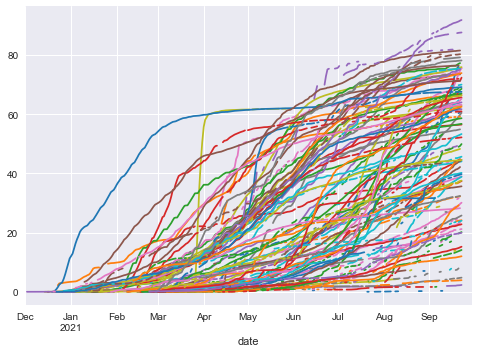

In [23]:
df_covid.set_index('date').groupby('location').people_vaccinated_per_hundred.plot();
plt.xlim((datetime.date(2020, 12, 1), datetime.date(2021, 9, 30)))
plt.show()

We will fill the missing data using the forward-fill method and save it to another DataFrame ``df_covid_fill``.

In [24]:
num_cols = ['total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
       'new_vaccinations_smoothed', 'total_vaccinations_per_hundred',
       'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred',
       'new_vaccinations_smoothed_per_million', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index', 'excess_mortality']

In [25]:
df_covid_fill = df_covid.copy()
df_covid_fill = df_covid_fill.sort_values(['location', 'date'])
df_covid_fill[num_cols] = df_covid_fill.groupby('location')[num_cols].fillna(method='ffill')

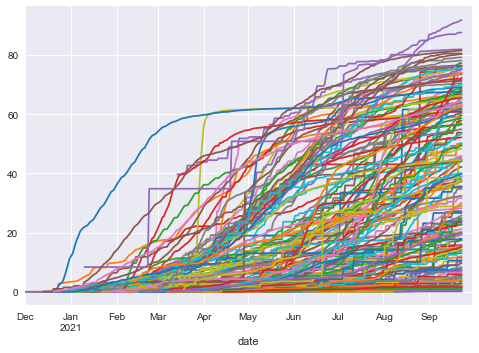

In [26]:
df_covid_fill.set_index('date').groupby('location').people_vaccinated_per_hundred.plot();
plt.xlim((datetime.date(2020, 12, 1), datetime.date(2021, 9, 30)))
plt.show()

We can visually confirm that the values have been forward-filled correctly.

2) Get the latest snapshot data of each country.

In [27]:
print('There are %i unique locations' % len(df_covid_fill.location.unique()))

There are 185 unique locations


In [28]:
latest_data_by_country = df_covid_fill.groupby('location').date.max().reset_index().rename(columns={'date':'maxdate'})
latest_data_by_country

,location,maxdate
0,Afghanistan,2021-09-23
1,Albania,2021-09-23
2,Algeria,2021-09-23
3,Angola,2021-09-23
4,Argentina,2021-09-23
...,...,...
180,Venezuela,2021-09-23
181,Vietnam,2021-09-23
182,Yemen,2021-09-23
183,Zambia,2021-09-23


In [29]:
df_covid_snapshot = df_covid_fill.merge(latest_data_by_country, how='left', on='location')
df_covid_snapshot = df_covid_snapshot.query('date == maxdate').drop(columns = 'maxdate')
df_covid_snapshot.shape

(185, 71)

3) Drop columns that are meaningless as a snapshot (since the data is now "stock" (cumulative figures), we should remove "flow" (incremental figures)).

In [30]:
flow_cols = ['new_cases','new_cases_smoothed','new_deaths','new_deaths_smoothed','new_cases_per_million', 
             'new_cases_smoothed_per_million','new_deaths_per_million',
             'new_deaths_smoothed_per_million', 'reproduction_rate','weekly_icu_admissions',
             'weekly_icu_admissions_per_million', 'weekly_hosp_admissions','weekly_hosp_admissions_per_million', 
             'new_tests','new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
             'positive_rate', 'tests_per_case', 'tests_units','new_vaccinations', 
             'new_vaccinations_smoothed','new_vaccinations_smoothed_per_million']
df_covid_snapshot = df_covid_snapshot.drop(columns = flow_cols)

----

## Problem Statements

**Question 1: Does richer country has higher vaccination rate?**

Visualizing the relationship between GDP per capita and vaccination rate.

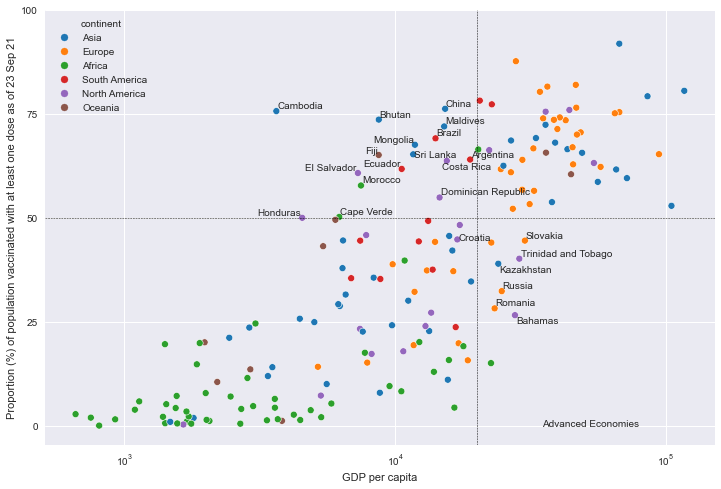

In [31]:
df_vis1 = df_covid_snapshot[['continent', 'location', 
                             'gdp_per_capita', 'people_vaccinated_per_hundred', 'AdvancedEconomy']].dropna()

fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(ax=ax, 
                data=df_vis1, 
                x='gdp_per_capita', 
                y='people_vaccinated_per_hundred', 
                hue='continent')
ax.set_xlabel('GDP per capita')
ax.set_xscale('log')
ax.set_ylabel('Proportion (%%) of population vaccinated with at least one dose as of %s' % today)
ax.set_yticks([0, 25, 50, 75, 100])

# Add reference lines
plt.axvline(20000, color='k', linewidth=0.5, linestyle='dashed')
plt.axhline(50, color='k', linewidth=0.5, linestyle='dashed')
plt.text(35000, 0, 'Advanced Economies')

# Add country name
texts = []
df_labels = df_vis1.query('(AdvancedEconomy == 1 and people_vaccinated_per_hundred < 50) or (AdvancedEconomy == 0 and people_vaccinated_per_hundred > 50)')
x = df_labels.gdp_per_capita.tolist()
y = df_labels.people_vaccinated_per_hundred.tolist()
s = df_labels.location.tolist()
for x, y, s in zip(x, y, s):
    texts.append(plt.text(x, y, s, fontsize=10))
adjust_text(texts) #arrowprops=dict(arrowstyle="-", color='k', lw=1)
plt.show()
fig.savefig('output/vaccination_by_gdp.png', dpi=300, bbox_inches='tight')

**Observations:**

* It appears that generally there is a strong trend between the GDP per capita and the vaccination rate but there are also notable outliers.
* However, when we exclude countires with extreme poverty, the relationship becomes less strong.

**Question 2: What factors best explain the difference in vaccination rate in addition to the economy?**

We will exclude extremely poor countries in Africa in this analysis since they would distort the result.

In [32]:
# Exclude poor countries and countries in Africa
df_covid_medium_to_rich = df_covid_snapshot.query('gdp_per_capita > 8000 and continent != "Africa"')

# Remove sparsely populated columns
df_covid_medium_to_rich = df_covid_medium_to_rich.loc[:, df_covid_medium_to_rich.isnull().sum() < 10]

# Correlation between Variables
print(df_covid_medium_to_rich.corr().people_vaccinated_per_hundred.sort_values().to_string())

cardiovasc_death_rate                 -0.535744
total_deaths_per_million              -0.195013
diabetes_prevalence                   -0.070114
stringency_index                      -0.063114
hospital_beds_per_thousand            -0.014566
total_deaths                           0.055765
population_density                     0.057086
total_cases                            0.094958
total_cases_per_million                0.097144
population                             0.105819
total_vaccinations                     0.144726
people_vaccinated                      0.145141
people_fully_vaccinated                0.146239
aged_70_older                          0.196131
aged_65_older                          0.199536
median_age                             0.278582
SH.IMM.MEA2                            0.280106
SH.IMM.HEPB                            0.292160
SH.IMM.MEAS                            0.322174
SH.IMM.IDPT                            0.392169
SH.IMM.POL3                            0

Excluding those that are heavily correlated by definition, the following factors appear to be strongly correlated with the vaccination rate.

- Life Expectancy
- Human Development Index
- GDP per capita
- Cardiovascular death rate *(negatively correlated)*
- Childhood vaccination rate (HIB3, POL3, DPT, etc.)

In [33]:
regr_vars = ['life_expectancy', 'human_development_index', 'gdp_per_capita', 'cardiovasc_death_rate',
             'SH.IMM.HIB3', 'SH.IMM.POL3', 'SH.IMM.IDPT']
df_regression = df_covid_medium_to_rich[np.append(['people_vaccinated_per_hundred', 'continent'], regr_vars)]   

# Drop missing values
df_regression = df_regression.dropna()

# Add log(GDP per capita)
df_regression['log_gdp_per_capita'] = np.log10(df_regression.gdp_per_capita)
regr_vars.append('log_gdp_per_capita')

# Normalize explanatory variables
regr_vars_normalized = []
for var in regr_vars:
    new_var = var + str('_normalized')
    regr_vars_normalized.append(new_var)
    df_regression[new_var] = (df_regression[var] - df_regression[var].mean()) / df_regression[var].std()
    
# Correlation amongst the explanatory variables
df_regression[regr_vars_normalized].corr()

,life_expectancy_normalized,human_development_index_normalized,gdp_per_capita_normalized,cardiovasc_death_rate_normalized,SH.IMM.HIB3_normalized,SH.IMM.POL3_normalized,SH.IMM.IDPT_normalized,log_gdp_per_capita_normalized
life_expectancy_normalized,1.000000,0.844485,0.556611,-0.683686,0.292368,0.273968,0.309949,0.667758
human_development_index_normalized,0.844485,1.000000,0.675165,-0.468837,0.347438,0.335356,0.373208,0.819126
gdp_per_capita_normalized,0.556611,0.675165,1.000000,-0.418740,0.314012,0.319792,0.320417,0.934881
cardiovasc_death_rate_normalized,-0.683686,-0.468837,-0.418740,1.000000,-0.074430,-0.041885,-0.041190,-0.472209
SH.IMM.HIB3_normalized,0.292368,0.347438,0.314012,-0.074430,1.000000,0.928322,0.956695,0.327273
SH.IMM.POL3_normalized,0.273968,0.335356,0.319792,-0.041885,0.928322,1.000000,0.953685,0.329130
SH.IMM.IDPT_normalized,0.309949,0.373208,0.320417,-0.041190,0.956695,0.953685,1.000000,0.336468
log_gdp_per_capita_normalized,0.667758,0.819126,0.934881,-0.472209,0.327273,0.329130,0.336468,1.000000


**Observations:**

- Life expectancy and HDI are strongly correlated (= 0.84).
- GDP and log(GDP) are obviously strongly correlated (=0.93).
- Life expectancy and Cardiovascular death rate are moderately negatively correlated (= -0.68).
- All the childhood vaccine indicators are strongly correlated (> 0.92).

In [34]:
def fit_OLS(df, X_vars):
    '''
    Fit ordinary least squares (linear regression) on the given dataset where the dependent variable 
    is the vaccinate rate and the explanatory variables are as given.
    
    Args:
        df (pd.DataFrame): dataset to perform regression on
        X_vars (list of str): list of column names in the dataset to be used as explanatory variables
            
    Returns:
        results (class fit_OLS): OLS regression result
    '''
    X = df[X_vars]
    y = df.people_vaccinated_per_hundred
    X = sm.add_constant(X)
    results = sm.OLS(y,X).fit()
    return results

In [35]:
# Fitting the regression on all explanatory variables
fit_OLS(df_regression, regr_vars_normalized).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     people_vaccinated_per_hundred   R-squared:                       0.545
Model:                                       OLS   Adj. R-squared:                  0.499
Method:                            Least Squares   F-statistic:                     11.84
Date:                           Wed, 06 Oct 2021   Prob (F-statistic):           6.22e-11
Time:                                   17:42:04   Log-Likelihood:                -354.68
No. Observations:                             88   AIC:                             727.4
Df Residuals:                                 79   BIC:                             749.7
Df Model:                                      8                                         
Covariance Type:                       nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 55.1161      1.532     35.970      0.000      52.066      58.166
life_expectancy_normalized             0.9531      3.797      0.251      0.802      -6.605       8.511
human_development_index_normalized     1.6857      4.417      0.382      0.704      -7.107      10.478
gdp_per_capita_normalized             -1.4625      4.902     -0.298      0.766     -11.220       8.295
cardiovasc_death_rate_normalized      -6.4808      2.384     -2.719      0.008     -11.226      -1.736
SH.IMM.HIB3_normalized                 4.4887      5.467      0.821      0.414      -6.392      15.370
SH.IMM.POL3_normalized                 3.5087      5.271      0.666      0.508      -6.984      14.001
SH.IMM.IDPT_normalized                -2.6091      6.926     -0.377      0.707     -16.396      11.178
log_gdp_per_capita_normalized          7.2333      6.401      1.130      0.262      -5.507      19.974
==============================================================================
Omnibus:                        0.706   Durbin-Watson:                   1.708
Prob(Omnibus):                  0.702   Jarque-Bera (JB):                0.484
Skew:                           0.181   Prob(JB):                        0.785
Kurtosis:                       3.031   Cond. No.                         11.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This regression suffers from multicollinearity issues.

Therefore, we have to reduce the number of explanatory variables to:

- Lift Expectancy (representing both HDI and Cardio death rate)
- log(GDP per capita)
- One of the childhool vaccination rate indicator

In [36]:
X_vars = ['log_gdp_per_capita_normalized','life_expectancy_normalized', 'SH.IMM.POL3_normalized']
fit_OLS(df_regression, X_vars).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     people_vaccinated_per_hundred   R-squared:                       0.490
Model:                                       OLS   Adj. R-squared:                  0.472
Method:                            Least Squares   F-statistic:                     26.94
Date:                           Wed, 06 Oct 2021   Prob (F-statistic):           2.66e-12
Time:                                   17:42:04   Log-Likelihood:                -359.70
No. Observations:                             88   AIC:                             727.4
Df Residuals:                                 84   BIC:                             737.3
Df Model:                                      3                                         
Covariance Type:                       nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            55.1161      1.573     35.034      0.000      51.988      58.245
log_gdp_per_capita_normalized     7.0060      2.171      3.227      0.002       2.688      11.324
life_expectancy_normalized        6.4824      2.132      3.041      0.003       2.243      10.722
SH.IMM.POL3_normalized            4.1165      1.681      2.449      0.016       0.774       7.459
==============================================================================
Omnibus:                        0.833   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.659   Jarque-Bera (JB):                0.614
Skew:                           0.204   Prob(JB):                        0.736
Kurtosis:                       3.018   Cond. No.                         2.39
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Based on the coefficients of the variables and the confidence interval, we can conclude that the most important factors that explain the vaccination rate in the descending order are:

1. GDP per capita
2. Life Expectancy
3. Childhood Vaccination Rate (using Polio as a proxy)

**Observations:**

- GDP per capita remains the most important factor both in terms of p-value and magnitude.
- However, almost equally, life expectancy also explains the vaccination rate very well. This probably reflects the healthcare system or the underlying health conditions of the population.
  - It should be noted that both log(GDP) and lift expectancy are strongly correlated themselves (0.66)
- Last but not least, using polio vaccination rate as a proxy for the attitude towards vaccination, the factor appears to moderately explain the vaccination rate fairly well i.e. the higher the childhood vaccination rate in a country, the higher the takeup of the COVID-19 vaccines.

Visualizing the scatterplots for all significant variables.

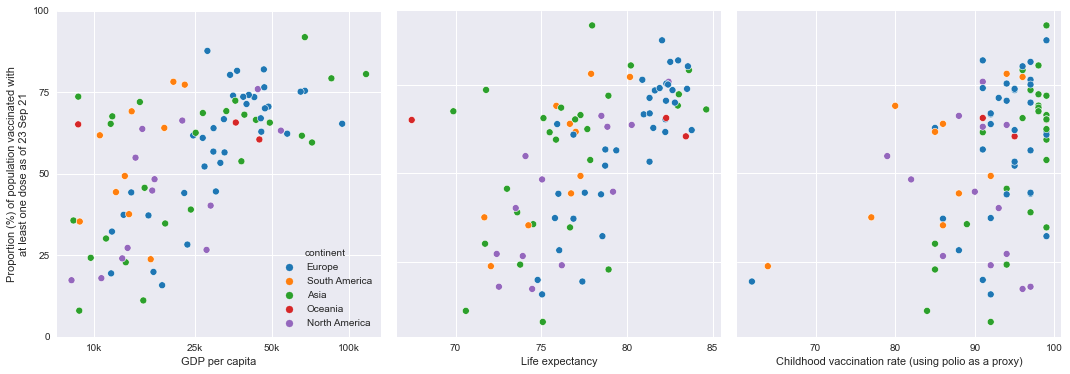

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

sns.scatterplot(ax=axes[0], 
                data=df_regression, 
                x='log_gdp_per_capita',
                y='people_vaccinated_per_hundred', 
                hue='continent')
axes[0].set_xticks([4, np.log10(25000), np.log10(50000), 5])
axes[0].set_xticklabels(['10k', '25k', '50k', '100k'])
axes[0].set_xlabel('GDP per capita')
axes[0].set_ylabel('Proportion (%%) of population vaccinated with\nat least one dose as of %s' % today)

sns.scatterplot(ax=axes[1], 
                data=df_regression, 
                x='life_expectancy',
                y='people_vaccinated_per_hundred', 
                hue='continent')
axes[1].legend().remove()
axes[1].set_xlabel('Life expectancy')
axes[1].set_xticks([70, 75, 80, 85])

sns.scatterplot(ax=axes[2], 
                data=df_regression, 
                x='SH.IMM.HIB3',
                y='people_vaccinated_per_hundred', 
                hue='continent')
axes[2].legend().remove()
axes[2].set_xticks([70, 80, 90, 100])
axes[2].set_xlabel('Childhood vaccination rate (using polio as a proxy)')

axes[0].set_yticks([0, 25, 50, 75, 100])

fig.subplots_adjust(wspace=0.05)
plt.show()
fig.savefig('output/regression_scatterplot.png', dpi=300, bbox_inches='tight')

**Question 3: How can we quantify or visualize Vaccine Hesitancy and which countries have the worst Vaccine Hesitancy problem?**

Focusing only on EU+EEA, UK, US & Canada where we know there is no vaccine supply issue at the time of this writing i.e. everyone who wishes to get vaccinated can get vaccinated.

In [38]:
countries_euna = ['Austria', 'Belgium',
       'Bulgaria', 'Canada', 'Croatia', 'Cyprus',
       'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany',
       'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 
       'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Norway', 'Poland',
       'Portugal', 'Romania',  'Slovakia', 'Slovenia',
       'Spain', 'Sweden', 'Switzerland',  'United Kingdom', 'United States']

Visualizing the time-series of vaccination rate in these countries.

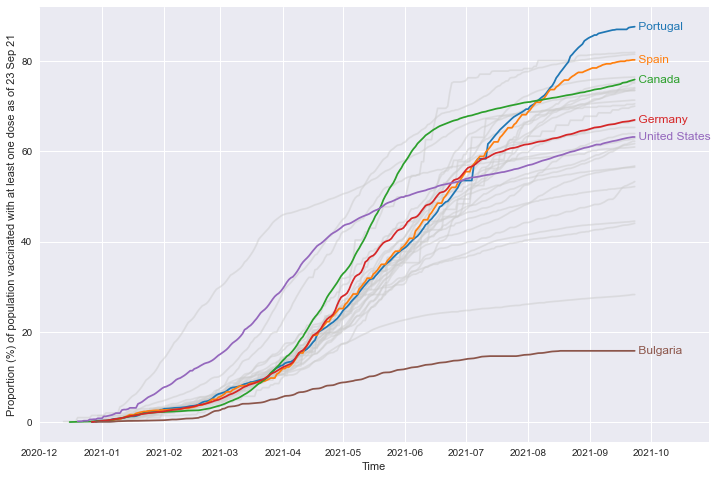

In [39]:
# Subsetting data
df_covid_fill_euna = df_covid_fill.query('location in @countries_euna and people_vaccinated_per_hundred >= 0.001')
highlights =['Portugal', 'Spain', 'Canada', 'Germany', 'United States', 'Bulgaria']

fig, ax = plt.subplots(figsize=(12,8))
for country in np.setdiff1d(countries_euna, highlights):
    data = df_covid_fill_euna.query('location == @country')
    ax.plot(data.date, data.people_vaccinated_per_hundred, color='0.8', alpha=0.5)

for country in highlights:
    data = df_covid_fill_euna.query('location == @country')
    line = ax.plot(data.date, data.people_vaccinated_per_hundred)
    ax.text(data.date.max(), 
            data.people_vaccinated_per_hundred.max(), 
            " " + country, 
            va='center', 
            color = line[0].get_color(),
            fontsize=12)

ax.set_xlabel('Time')
ax.set_ylabel('Proportion (%%) of population vaccinated with at least one dose as of %s' % today)

    
plt.xlim((datetime.date(2020, 12, 1), datetime.date(2021, 10, 30)))
plt.show()

fig.savefig('output/time-series-example.png', dpi=300, bbox_inches='tight')

Despite having no vaccine supply issue, we can see clearly that Bulgaria has the lowest vaccination rate and, as such, has the worst vaccine hesitancy problem. On the other hand, the vaccination rates in Portugal and Spain have increased steadily and only begun to slow down past 80% point as most of their adult population has received their jab i.e. they started to run out of people to vaccinate.

Meanwhile, when we look at countries such as the US, Germany and Canada, we can observe a “bend” in the curve starting at around 45%, 60% and 65% respectively. Without vaccine hesitancy, we would have expected the curve to continue climbing smoothly like in Portugal and Spain.

To make the problem of vaccine hesitancy stand out more, we can revisualize this graph by counting the number days needed to increase the vaccination rate by 5%.

In [40]:
def add_vac_milestone(df_snapshot, milestones, df_time=df_covid_fill):
    
    '''
    Add the requested vaccination milestones, namely, the dates on which the administration of 
    the first dose reach a certain proportion of the population and calculate the gaps in 
    between the dates.
    
    Args:
        df_snapshot (pd.DataFrame): cross-section dataset of covid figures by country
        milestones (list of int): vaccination milestones (first dose admin reaching x% 
                                  of the population) to be calculated from the time-series 
        df_time (pd.DataFrame): time-series dataset of covid figures
    
    Returns:
        df_snapshot (pd.DataFrame): cross-section dataset with vaccination milestones added
        col_names_milestones (list): list of column names with the dates reaching the milestones
        col_names_lags (list): list of column names with the gaps (in days) between the milestones
    '''
    
    col_names_milestones = []
    col_names_lags = []    
    
    for milestone in milestones:
        new_col_name = 'date_reach' + str(milestone)
        col_names_milestones.append(new_col_name)
        if milestone == 0:
            df_temp = df_time.query('people_vaccinated_per_hundred >= 0.001')
        else:
            df_temp = df_time.query('people_vaccinated_per_hundred >= @milestone')           
        df_temp = df_temp.groupby('location').date.min().reset_index().rename(columns=dict(date=new_col_name))
        df_snapshot = df_snapshot.merge(df_temp, on='location', how='left')
    
    for i in range(len(milestones) - 1):
        label = 'lag_' + str(milestones[i]) + 'to' + str(milestones[i+1])
        col_names_lags.append(label)
        df_snapshot[label] = (df_snapshot['date_reach'+str(milestones[i+1])] - 
                              df_snapshot['date_reach'+str(milestones[i])]).dt.days
    return df_snapshot, col_names_milestones, col_names_lags

Create the dataset with milestones

In [49]:
milestones = np.arange(0, 85, 5)
df_euna_vac_lags, col_names_milestones, col_names_lags = add_vac_milestone(
    df_covid_snapshot.query('location in @countries_euna'), milestones)
df_euna_vac_lags = df_euna_vac_lags.set_index('location')
df_euna_vac_lags[col_names_lags].head(5)

,lag_0to5,lag_5to10,lag_10to15,lag_15to20,lag_20to25,lag_25to30,lag_30to35,lag_35to40,lag_40to45,lag_45to50,lag_50to55,lag_55to60,lag_60to65,lag_65to70,lag_70to75,lag_75to80
location,,,,,,,,,,,,,,,,
Austria,63,17,20,12.0,11.0,9.0,11.0,9.0,12.0,12.0,16.0,42.0,NaN,NaN,NaN,NaN
Belgium,63,21,15,9.0,11.0,9.0,11.0,11.0,9.0,8.0,5.0,6.0,12.0,27.0,NaN,NaN
Bulgaria,88,48,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Canada,83,16,11,8.0,7.0,7.0,8.0,6.0,6.0,5.0,7.0,7.0,11.0,36.0,57.0,NaN
Croatia,72,21,22,13.0,8.0,12.0,22.0,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*Visualization of the vaccination milestones*

In [42]:
def visualize_milestones(highlight_countries, background_countries=[], df=df_euna_vac_lags):
    
    '''
    Visualize the vaccination milestones and return the figure.
    
    Args:
        df_snapshot (pd.DataFrame): cross-section dataset of covid figures by country
        milestones (list of int): vaccination milestones (first dose admin reaching x% 
                                  of the population) to be calculated from the time-series 
        df_time (pd.DataFrame): time-series dataset of covid figures
    
    Returns:
        fig (plt object): rendered visualization
    '''    
    
    
    fig, ax = plt.subplots(figsize=(12,8))
    x = milestones[1:]

    for country in background_countries:
        y = df.loc[country, col_names_lags]
        ax.plot(x, y, color='0.8', alpha=0.5)

    for country in highlight_countries:
        y = df.loc[country, col_names_lags]
        line = ax.plot(x, y, 'o-', alpha=0.7, label=country) 

    ax.legend()
    ax.set_xticks(np.arange(0, 85, 5))
    ax.set_xlim((0,85))
    ax.set_xlabel('Vaccination Milestone with at least one dose reaching x% of the population')
    ax.set_ylabel('Number of days needed to reach the next Vaccination Milestone')
    plt.show()
    
    return fig

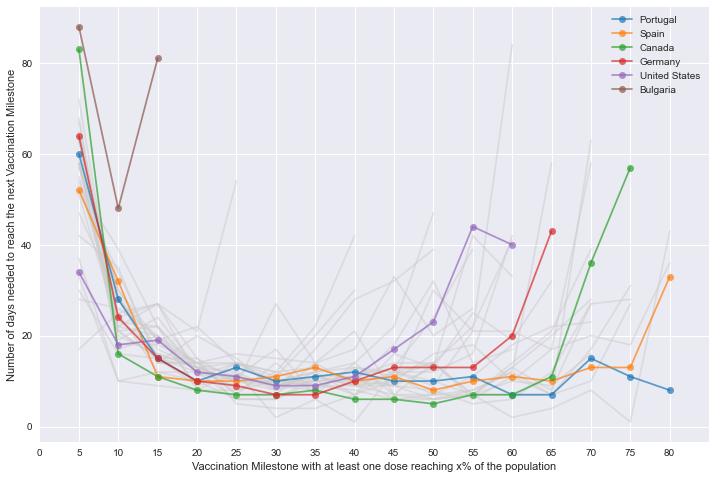

In [43]:
highlights =['Portugal', 'Spain', 'Canada', 'Germany', 'United States', 'Bulgaria']
fig = visualize_milestones(highlights, np.setdiff1d(countries_euna, highlights))
fig.savefig('output/milestones_all.png', dpi=300, bbox_inches='tight')

Compared to the previous graph, this graph is much easier for us to see the problem of vaccine hesitancy easily. 

Almost every country follows a very similar trajectory; initially, it took more than a month to vaccinate the first 5% of the population since it involved ramping up the facilities, system, and there was also a vaccine delivery delay at the beginning. 

But as the vaccination campaign progressed, the number of days required to reach the subsequent 5% reduced over time. And in those countries without much vaccine hesitancy (Portugal, Spain, etc.), the intervals between each milestone did not increase significantly until they reached the point where they have almost vaccinated every adult. 

But when we look at countries with vaccine hesitancy issue, we can see a sudden sharp increase (e.g. Germany took more than 40 days to increase vaccination rate from 60% to 65%.)

We can now deep-dive into each region as follows:

### 1. Southern European Countries (Cyprus, Greece, Italy, Malta, Portugal, Spain)

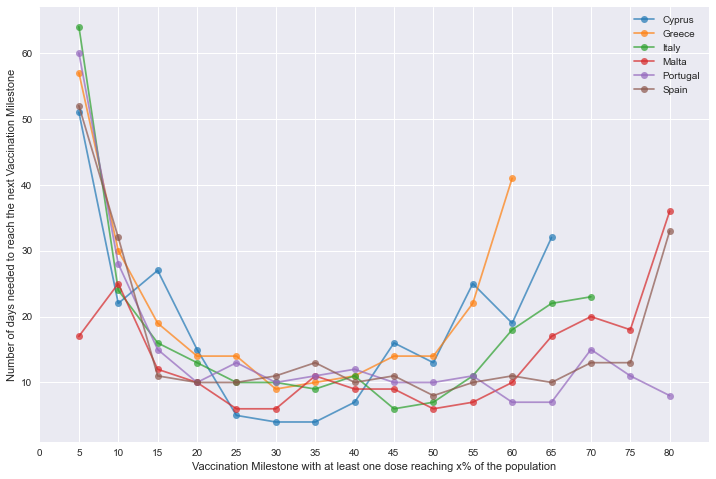

In [45]:
southern_europe = ['Cyprus', 'Greece', 'Italy', 'Malta', 'Portugal','Spain']
fig = visualize_milestones(southern_europe)
fig.savefig('output/milestones_southern.png', dpi=300, bbox_inches='tight')

**Observations:**

- Spain, Portugal and Malta are doing well, and the vaccination rate has exceeded 80% without much vaccine hesitancy.
- Italy started to see a moderate slowdown in vaccination rate.
- Greece and Cyprus have a moderate issue of vaccine hesitancy and struggle to increase the vaccination rate past 60% and 65% respectively.

### 2. Anglophone countries (US, UK, Canada, Ireland)

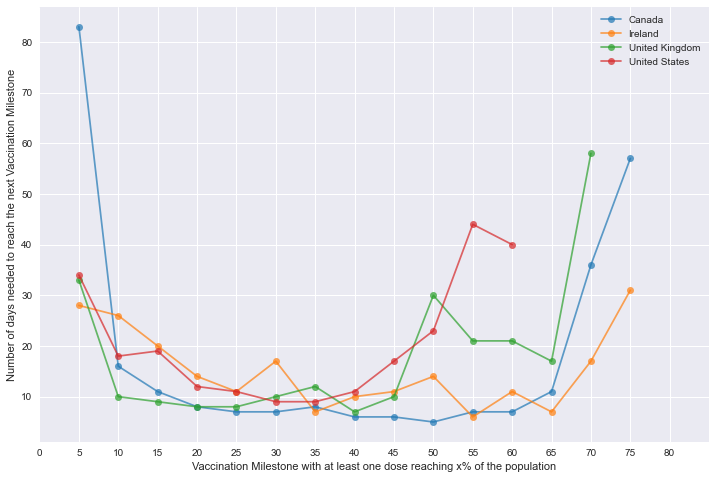

In [44]:
anglosphere_countries = ['Canada', 'Ireland', 'United Kingdom', 'United States']
fig = visualize_milestones(anglosphere_countries)
fig.savefig('output/milestones_anglo.png', dpi=300, bbox_inches='tight')

**Observations:**

- UK, Ireland and Canada experience a significant slowdown in vaccination rate past the 65% mark and the US started hitting the wall much earlier at the 50% mark. 
- The vaccine hesitancy problem is the worst in the US, followed by UK, Canada, and Ireland.

### 3. Western European Countries

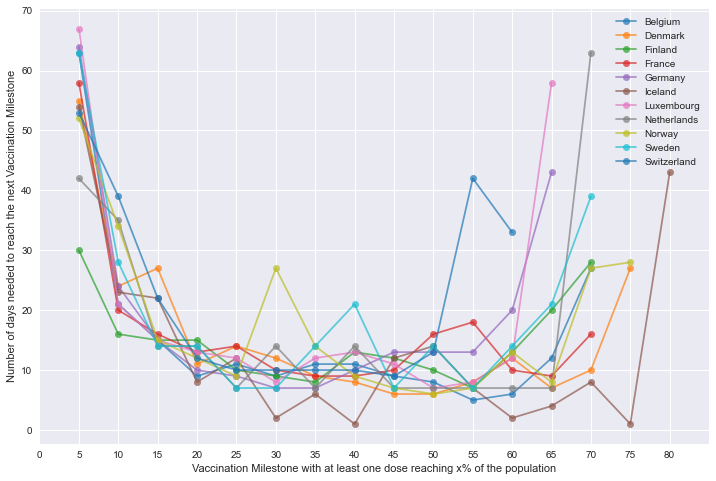

In [46]:
western_europe = ['Belgium',  'Denmark',  'Finland', 'France', 'Germany', 'Iceland', 'Luxembourg', 
                  'Netherlands', 'Norway', 'Sweden', 'Switzerland']
fig = visualize_milestones(western_europe)
fig.savefig('output/milestones_western.png', dpi=300, bbox_inches='tight')

**Observations:**

- A few countries stand out in terms of vaccine hesitancy namely the Netherlands, Luxembourg, Germany, Sweden and Switzerland.
- Iceland took almost 1.5 months to increase the rate from 75% to 80% but that was as a result of widening the eligibility to vaccinate teenagers rather than the hesitancy itself.
- France saw the vaccination rate slow down around 50% and 55% mark and since then introduced strict rules on vaccination proof to access public venues. That acted as an impetus to accelerate vaccination rate, taking fewer than 10 days to increase to 60% and 65%.

### 4. Central and Eastern European Countires

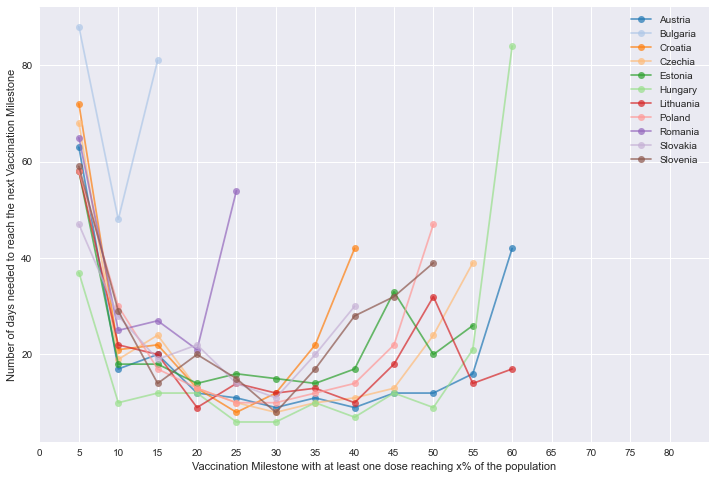

In [47]:
sns.set_palette('tab20',20)
central_eastern_europe = ['Austria', 'Bulgaria', 'Croatia',
       'Czechia', 'Estonia',  'Hungary', 'Lithuania', 'Poland',
        'Romania',  'Slovakia', 'Slovenia']
fig = visualize_milestones(central_eastern_europe)
fig.savefig('output/milestones_cee.png', dpi=300, bbox_inches='tight')

**Observations:**

- Amongst all the regions, Central and Eastern Europe have the lowest vaccination rate and also the most serious vaccine hesitancy problem. None of the countries have exceeded 65% mark at the time of this writing. Bulgaria has vaccinated less than 20% of its population; Romania less than 30%; Croatia and Slovakia less than 45%, despite all these countries having ample supply of the vaccines.

**Overall Observations:**
- By generalizing our observations at regional level,

  * Southern Europeans are least hesitant at getting vaccinated.
  * This is followed by Western Europeans with some notable exceptions such as the Dutch, Swiss, and German.
  * English-speaking countries (UK/Canada/Ireland) started off very strongly until reaching the 65% mark but are now facing a significant challenge to encourage the remainder of the adult population to get vaccinated.
  * Despite being the first country to start the mass-vaccination program, the United States faced a significant headwind and has fallen much behind the other countries.
  * Lastly, Central and Eastern Europeans are the most resistant in getting vaccinated.

- It would be an interesting research question to see if there is any sociological/political/psychological reason why Central and Eastern Europeans are so resistant to receiving the COVID-19 vaccines while Southern Europeans are much more receptive.